In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Potential important resource:
https://stellargraph.readthedocs.io/en/stable/demos/embeddings/graphsage-unsupervised-sampler-embeddings.html#Extracting-node-embeddings


## Exercise 4, Advanced Network Science:
- Run graphsage again on the cora data, but this time use the embeddings as the input of some similarity function that allows you to condense the graph.
- Find communities on the cora data with label percolation and use them to condense the graph. Compare it visually with the results of the previous approach.



In [2]:
!pip install tqdm

In [3]:
import sys
sys.path.append('/content/drive/MyDrive/ADVANCED_NETWORK_SCIENCE/exercise_4')
from graphsage.encoders import Encoder
from graphsage.aggregators import MeanAggregator

sys.path.append('/content/drive/MyDrive/ADVANCED_NETWORK_SCIENCE/exercise_4/cora')


# IMPORTS

In [30]:
import torch, sys, random
import numpy as np
import pandas as pd
import torch.nn as nn
import networkx as nx
from sklearn.manifold import TSNE
from torch.autograd import Variable
from sklearn.metrics import f1_score
from graphsage.encoders import Encoder
from graphsage.aggregators import MeanAggregator
from matplotlib import pyplot as plt
from collections import Counter
from tqdm import tqdm
import pandas as pd
from sklearn.decomposition import PCA

# GRAPHSAGE'S NODE ENCODER

In [5]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F

class Encoder(nn.Module):
    """
    Encodes a node's using 'convolutional' GraphSage approach
    """
    def __init__(self, features, feature_dim,
            embed_dim, adj_lists, aggregator,
            num_sample=10,
            base_model=None, gcn=False, cuda=False,
            feature_transform=False):
        super(Encoder, self).__init__()

        self.features = features
        self.feat_dim = feature_dim
        self.adj_lists = adj_lists
        self.aggregator = aggregator
        self.num_sample = num_sample
        if base_model != None:
            self.base_model = base_model

        self.gcn = gcn
        self.embed_dim = embed_dim
        self.cuda = cuda
        self.aggregator.cuda = cuda
        self.weight = nn.Parameter(
                torch.FloatTensor(embed_dim, self.feat_dim if self.gcn else 2 * self.feat_dim))
        init.xavier_uniform_(self.weight)

    def forward(self, nodes):
        """
        Generates embeddings for a batch of nodes.

        nodes     -- list of nodes
        """
        neigh_feats = self.aggregator.forward(nodes, [self.adj_lists[int(node)] for node in nodes],
                self.num_sample)
        if not self.gcn:
            if self.cuda:
                self_feats = self.features(torch.LongTensor(nodes).cuda())
            else:
                self_feats = self.features(torch.LongTensor(nodes))
            combined = torch.cat([self_feats, neigh_feats], dim=1)
        else:
            combined = neigh_feats
        combined = F.relu(self.weight.mm(combined.t()))
        return combined



# DEFINING A SUPERVISED GRAPH SAGE MODEL

- Inputs = number of classes, encoder ('enc')
- Methods = forward to compute node embeddings, loss to calculate cross entropy loss

In [6]:
class SupervisedGraphSage(nn.Module):
    def __init__(self, num_classes, enc):
        super(SupervisedGraphSage, self).__init__()
        self.enc = enc
        self.xent = nn.CrossEntropyLoss()
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, enc.embed_dim))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, nodes):
        embeds = self.enc(nodes)
        scores = self.weight.mm(embeds)
        return scores.t()

    def loss(self, nodes, labels):
        scores = self.forward(nodes)
        return self.xent(scores, labels.squeeze().to("cuda"))



# LOADING THE CORA DATASET (data, labels, graph structure)

- In addition, the function turns the df into an adjacency list of the graph
- And returns feature data (feat_data), labels (labels), adjacency lists (adj_lists) and a mapping of the nodes IDs to indices (node_map)

In [7]:
def load_cora():
   df = pd.read_csv("/content/drive/MyDrive/ADVANCED_NETWORK_SCIENCE/exercise_4/cora/cora.content", sep = "\t", header = None)
   feat_data = df.values[:,1:-1].astype(float)
   labels = pd.factorize(df.iloc[:,-1])[0]
   node_map = df.reset_index().set_index(0)["index"].to_dict()
   G = nx.read_edgelist("/content/drive/MyDrive/ADVANCED_NETWORK_SCIENCE/exercise_4/cora/cora.cites", nodetype = int)
   adj_lists = {}
   for n in G.nodes():
      adj_lists[node_map[n]] = {node_map[n2] for n2 in G.neighbors(n)}
   return G, feat_data, labels, adj_lists, {node_map[n]: n for n in node_map}

G, feat_data, labels, adj_lists, node_map = load_cora()

# nn.Embedding module to create an embedding layer

In [8]:
# here I am creating graph embeddings from the feat_data (shape 2708, 1433), each one with length 1433 and 1 dimension
# feat_data = 2708 documents (nodes),
            # 1433 words (features)
features = nn.Embedding(feat_data.shape[0], feat_data.shape[1]) # the features are NOT the embeddings!!
features.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad = False)
features.cuda()

Embedding(2708, 1433)

In [9]:
agg1 = MeanAggregator(features, cuda = True)
enc1 = Encoder(features, feat_data.shape[1], 128, adj_lists, agg1, gcn = True, cuda = True) # this sets the size of the embedding to be 128
agg2 = MeanAggregator(lambda nodes : enc1(nodes).t(), cuda = True)
enc2 = Encoder(lambda nodes : enc1(nodes).t(), enc1.embed_dim, 128, adj_lists, agg2, base_model = enc1, gcn = True, cuda = True)
enc1.num_samples = 5
enc2.num_samples = 5

# Training

- Randomly select a batch of training nodes
- Compute the loss (predictions vs true labels)
- Perform backpropagation using SGD

In [10]:
graphsage = SupervisedGraphSage(len(set(labels)), enc2)
graphsage.cuda()
rand_indices = np.random.permutation(feat_data.shape[0])
test = rand_indices[:1000]
val = rand_indices[1000:1500]
train = list(rand_indices[1500:])

optimizer = torch.optim.SGD(filter(lambda p : p.requires_grad, graphsage.parameters()), lr = 0.7)
for batch in range(100):
   batch_nodes = train[:256]
   random.shuffle(train)
   optimizer.zero_grad()
   loss = graphsage.loss(batch_nodes, Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
   loss.backward()
   optimizer.step()
   sys.stderr.write(f"Batch {batch}, Loss {loss.data.item()}\n")

Batch 0, Loss 1.9306738376617432
Batch 1, Loss 1.9084856510162354
Batch 2, Loss 1.8864264488220215
Batch 3, Loss 1.8472485542297363
Batch 4, Loss 1.8172013759613037
Batch 5, Loss 1.7637152671813965
Batch 6, Loss 1.7612149715423584
Batch 7, Loss 1.634437084197998
Batch 8, Loss 1.570483922958374
Batch 9, Loss 1.5955432653427124
Batch 10, Loss 1.4820899963378906
Batch 11, Loss 1.4384044408798218
Batch 12, Loss 1.4110643863677979
Batch 13, Loss 1.274393916130066
Batch 14, Loss 1.2709256410598755
Batch 15, Loss 1.232149600982666
Batch 16, Loss 1.1399534940719604
Batch 17, Loss 1.1044590473175049
Batch 18, Loss 1.0418483018875122
Batch 19, Loss 0.9420552849769592
Batch 20, Loss 0.9070433974266052
Batch 21, Loss 0.8768647909164429
Batch 22, Loss 0.9167658090591431
Batch 23, Loss 0.92589271068573
Batch 24, Loss 0.9443433880805969
Batch 25, Loss 0.8392869234085083
Batch 26, Loss 0.8749992847442627
Batch 27, Loss 0.6636366844177246
Batch 28, Loss 0.7355968356132507
Batch 29, Loss 0.7167765498161

# F1 Evaluation

In [11]:
val_output = graphsage.forward(val)
sys.stderr.write(f"Validation F1: {f1_score(labels[val], val_output.data.cpu().numpy().argmax(axis = 1), average = 'micro')}\n")

test_output = graphsage.forward(test)
sys.stderr.write(f"Test F1: {f1_score(labels[test], test_output.data.cpu().numpy().argmax(axis = 1), average = 'micro')}\n")

Validation F1: 0.848
Test F1: 0.863


# Retrieving embeddings and finding similarities based on similarity function

In [12]:
embeds = graphsage.enc(sorted(rand_indices)) # embeddings retrieved from the encoder function
preds = graphsage.forward(sorted(rand_indices)) # predicions retrieved from the forward function
tsne_data = TSNE(n_components=2,init='random').fit_transform(embeds.T.cpu().detach().numpy()) # dimensionality reduction of the embeddings (exercise 2)
pred_labels = np.argmax(preds.detach().cpu().numpy(),axis=1)

In [13]:
embeds.t().shape
# 2708 documents (nodes),
# 128 reduced features (words)

torch.Size([2708, 128])

In [14]:
pred_labels

array([0, 1, 2, ..., 5, 6, 0])

### This snippet is part of exercise 2 but helps understand the concepts

Counter({0: 832, 3: 429, 5: 410, 4: 379, 6: 292, 2: 210, 1: 156})
first
second
third


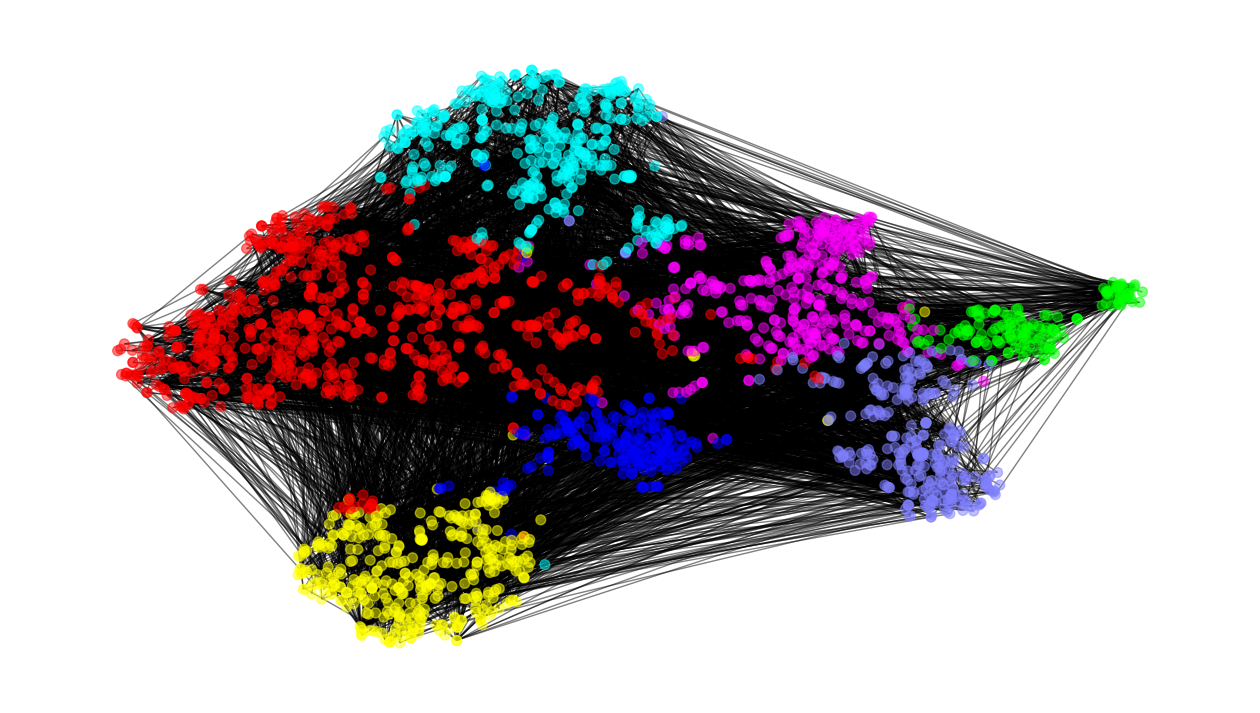

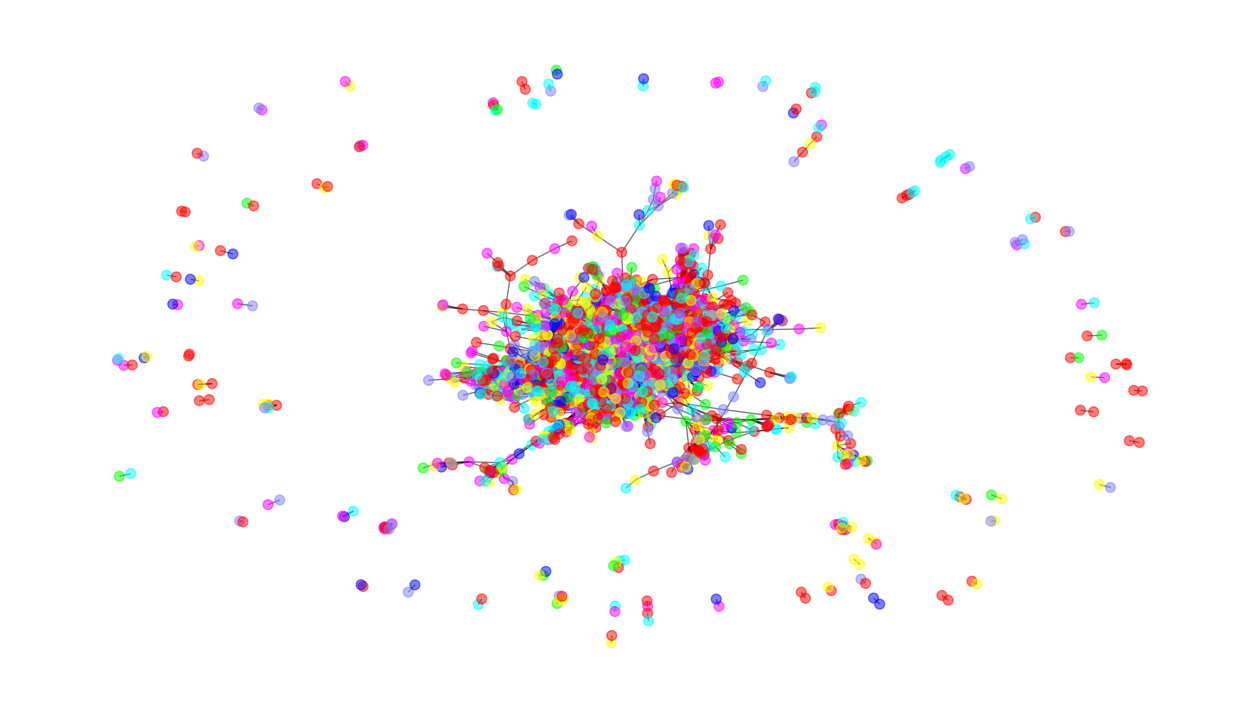

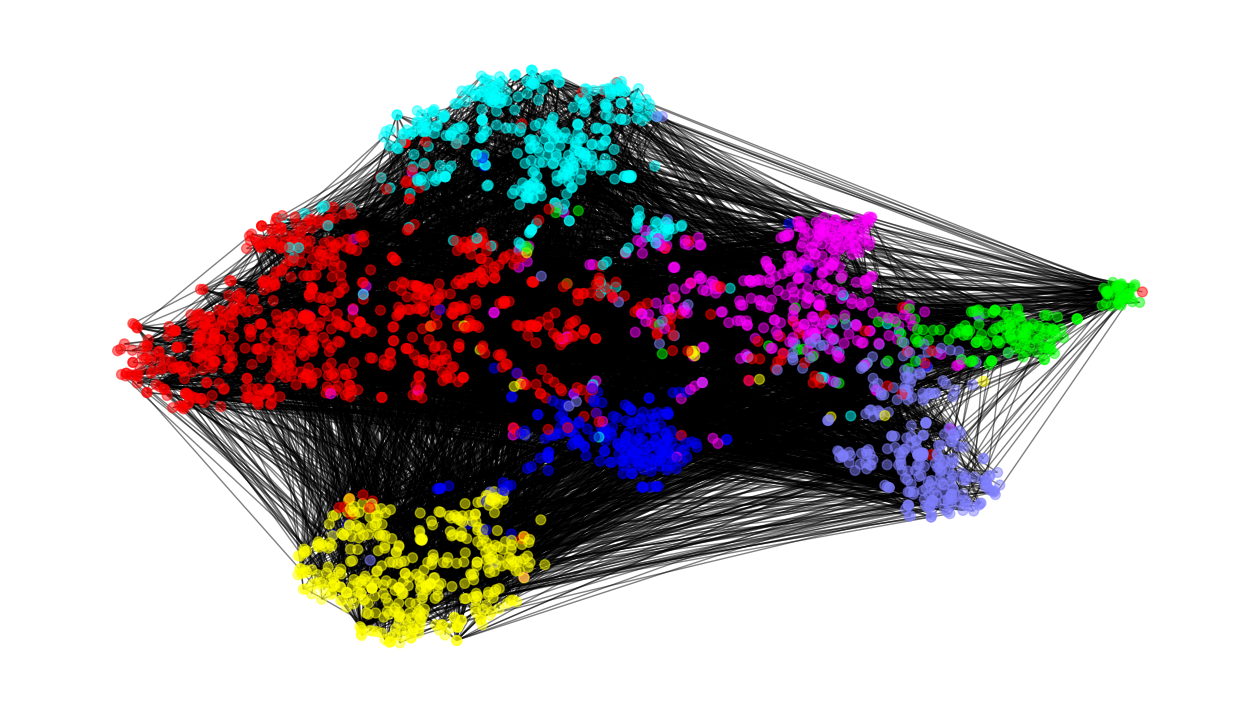

In [15]:
# visualizations from exercise 2
fig,ax = plt.subplots(figsize=(16,9))
pos = {ind:point for point, ind in zip(tsne_data,G.nodes)}
node_color_dict = {0:[1,0,0],1:[0,1,0],2:[0,0,1],3:[0,1,1],4:[1,0,1],5:[1,1,0],6:[0.5,0.5,1]}
node_color = [node_color_dict[pred] for pred in pred_labels]
true_node_color = [node_color_dict[pred] for pred in labels]
print(Counter(pred_labels))

nx.draw(G,pos=pos,ax=ax,node_size=50,alpha=0.5,node_color=node_color)
fig.savefig('temp.svg')
print('first')

fig2,ax2 = plt.subplots(figsize=(16,9))
nx.draw(G,ax=ax2,pos=nx.spring_layout(G),node_size=50,alpha=0.5,node_color=node_color)
fig2.savefig('temp2.svg')
print('second')

fig3,ax3 = plt.subplots(figsize=(16,9))
nx.draw(G,ax=ax3,pos=pos,node_size=50,alpha=0.5,node_color=true_node_color)
fig3.savefig('temp3.svg')
print('third')

In [16]:
from networkx.drawing.nx_pylab import kamada_kawai_layout
def manhattan_distance(node_embeddings, threshold_value):
    # manhattan distance
    manhattan_distances = torch.cdist(node_embeddings, node_embeddings, p=1)
    # Define a threshold to determine edge connections
    threshold = threshold_value
    # Create a new empty graph for the condensed graph
    F = nx.Graph()
    # Add nodes to the condensed graph
    num_nodes = len(node_embeddings)
    F.add_nodes_from(range(num_nodes))
    # Add edges to the condensed graph based on the threshold
    for i in tqdm(range(num_nodes)):
        for j in range(i + 1, num_nodes):
            if manhattan_distances[i, j] <= threshold:
                F.add_edge(i, j)
    # visualization
    fig,ax = plt.subplots(figsize=(10,9))
    pos = kamada_kawai_layout(F)
    node_color_dict = {0:[1,0,0],1:[0,1,0],2:[0,0,1],3:[0,1,1],4:[1,0,1],5:[1,1,0],6:[0.5,0.5,1]}
    node_color = [node_color_dict[pred] for pred in pred_labels]

    nx.draw(F,pos=pos,ax=ax,node_size=50,alpha=0.5,node_color=node_color)
    print(len(F.nodes))
  # Display the graph
    plt.show()

In [35]:
transposed_embeds = embeds.T.cpu().detach()
transposed_embeds.shape

# 2708 nodes
# 128 features - I am reducing these features using PCA for computational ease

torch.Size([2708, 128])

In [44]:
pca = PCA(n_components = 10)

# Fit the PCA model to your data
pca.fit(transposed_embeds)

# Transform the data to the lower-dimensional space
pca_data = pca.transform(transposed_embeds)

principalDf = pd.DataFrame(data = pca_data
             , columns = ['principal component 1', 'principal component 2', 'principal component 3',
                          'principal component 4', 'principal component 5', 'principal component 6',
                          'principal component 7', 'principal component 8', 'principal component 9',
                          'principal component 10'])

principalDf

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10
0,-0.031595,2.537860,-0.479566,0.428936,0.118964,-0.567183,-0.061688,-0.239567,0.375526,0.150656
1,-0.942131,-2.383117,-1.009087,0.339281,0.696244,-0.646888,0.887288,0.018614,-0.165566,0.099038
2,0.726505,-0.672612,-2.014028,0.045275,-1.857217,1.353069,0.477540,-0.028584,0.030498,0.035157
3,0.548731,-0.961317,-1.372288,-0.363583,-2.074302,0.881839,0.212587,0.024360,0.055797,0.037572
4,-3.880034,1.371618,3.883164,0.046493,0.628656,1.913388,0.770207,0.194002,-0.087106,-0.088736
...,...,...,...,...,...,...,...,...,...,...
2703,2.761837,-1.491557,0.640607,0.102969,-0.421763,0.778568,0.185776,-0.039326,0.027783,-0.065361
2704,2.059659,-2.472552,1.304659,-0.073227,-0.318950,-0.530716,0.103922,-0.323948,0.215985,0.123639
2705,3.304894,-2.156087,2.183252,0.233183,0.344500,-0.376575,0.459765,-0.441045,0.278189,-0.137776
2706,-1.762154,-1.422742,-0.929096,1.992339,0.674592,0.048058,-0.976328,0.021636,-0.030954,-0.072299


In [18]:
torch.cdist(transposed_embeds, transposed_embeds, p=1).shape

torch.Size([2708, 2708])

In [19]:
torch.cdist(transposed_embeds, transposed_embeds, p=1)


tensor([[ 0.0000, 42.4173, 37.5371,  ..., 50.2513, 40.6098, 12.7971],
        [42.4173,  0.0000, 33.6122,  ..., 44.2235, 23.2752, 44.4684],
        [37.5371, 33.6122,  0.0000,  ..., 46.6877, 36.6347, 40.2370],
        ...,
        [50.2513, 44.2235, 46.6877,  ...,  0.0000, 51.7658, 48.5536],
        [40.6098, 23.2752, 36.6347,  ..., 51.7658,  0.0000, 44.7230],
        [12.7971, 44.4684, 40.2370,  ..., 48.5536, 44.7230,  0.0000]])

In [51]:
# manhattan distance
manhattan_distances = torch.cdist(torch.FloatTensor(pca_data), torch.FloatTensor(pca_data), p=1)
# Define a threshold to determine edge connections
threshold = 30
# Create a new empty graph for the condensed graph
F = nx.Graph()
# Add nodes to the condensed graph
num_nodes = len(pca_data)
F.add_nodes_from(range(num_nodes))
    # Add edges to the condensed graph based on the threshold
for i in tqdm(range(num_nodes)):
    for j in range(i + 1, num_nodes):
        if manhattan_distances[i, j] <= threshold:
            F.add_edge(i, j)

100%|██████████| 2708/2708 [00:55<00:00, 48.40it/s] 


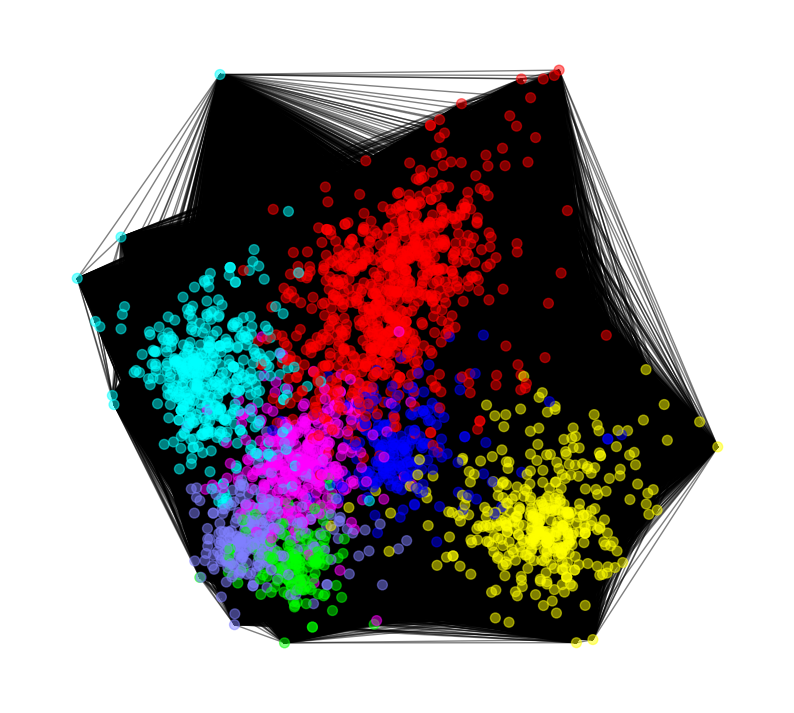

In [67]:
# visualization
fig,ax = plt.subplots(figsize=(10,9))
pos = {ind: (point[0], point[1]) for ind, point in enumerate(pca_data)}
node_color_dict = {0:[1,0,0],1:[0,1,0],2:[0,0,1],3:[0,1,1],4:[1,0,1],5:[1,1,0],6:[0.5,0.5,1]}
node_color = [node_color_dict[pred] for pred in pred_labels]

nx.draw(F,pos=pos,ax=ax,node_size=50,alpha=0.5,node_color=node_color)
# Display the graph
plt.show()